# **MECS6616 Spring 2025 - Project 3**

# **Introduction**

***IMPORTANT:***
- **Before starting, make sure to read the [Assignment Instructions](https://courseworks2.columbia.edu/courses/215046/pages/assignment-instructions) page on Courseworks to understand the workflow and submission requirements for this project.**

**FOR PROJECT 3!!!**
- Apart from the link to your notebook, you are also required to submit your collected data `.pkl` files and your chosen model checkpoint `.pth` files to Coursework. You will have two files each for parts 2 and 3 for a total of 4 files.
- Your part 2 files should be named `data_pt2.pkl` and `dynamics_pt2.pth`.
- Your part 3 files should be named `data_pt3.pkl` and `dynamics_pt3.pth`.
- You should put the link to your notebook in the "Comment" section of your submission.

## **Project Setup (do NOT change)**

***IMPORTANT:***
- Do NOT change this "*Project Setup*" section
- Do NOT install any other dependencies or a different version of an already provided package. You may, however, import other packages


In [ ]:
# DO NOT CHANGE

# After running this cell, the folder 'mecs6616_sp25_project3' will show up in the file explorer on the left (click on the folder icon if it's not open)
# It may take a few seconds to appear
!git clone https://github.com/roamlab/mecs6616_sp25_project3.git

fatal: destination path 'mecs6616_sp25_project3' already exists and is not an empty directory.


In [ ]:
# DO NOT CHANGE

# move all needed files into the working directory. This is simply to make accessing files easier
!mv /content/mecs6616_sp25_project3/* /content/

mv: cannot stat '/content/mecs6616_sp25_project3/*': No such file or directory


In [ ]:
# Using ray for data collection is optional
!pip install ray

# Starter Code Explanation

This project uses a simulated robot provided by the `Robot` class in `robot.py` file. Each robot is initialized with a corresponding forward dynamics (the base class for forward dynamics definition is in `arm_dynamic_base.py`). The arm_teacher is initialized with the provided ground truth forward dynamics, as defined in `arm_dynamics_teacher.py`. You are welcome to look in-depth into this file to understand how the ground truth forward dynamics is computed for an arm, given its number of links, link mass, and viscous friction of the environment - this is recommended but not necessary to successfully complete this assignment.

The Robot class inside `robot.py` which provides the interface for controlling the robot arm i.e it provides you with some functions to set/get the state and set the action for the arm and take a step using the `Robot.advance()` method. The state of the arm is a 2n-dimensional vector: n joint positions [rad] + n joint velocities [rad/s] and the action is defined as the n torques (in N-m) applied to n joints respectively.

In addition to `arm_dynamics_teacher.py` which contains the ground truth forward dynamics, you will use `arm_dynamics_student.py`, the student dynamics which internally uses a neural network model.

# Part 1: Implement Model Predictive Control



You will implement this controller by completing the MPC class. Specifically, you will implement the compute_action() method by following the algorithm discussed in the lecture. As with previous projects you are free to implement additional methods as needed or change the initialization if need be. While scoring your controller, you will be creating an instance of the MPC class and passing it to the scoring function so ensure that the arguments to the compute_action method remain the same.

Although you do not need to understand how the ArmDynamicsTeacher class works, you could use the compute_fk() method from the class. This will allow you to convert from the state value (represented as array of shape (2*n, 1) where n is num_links) to final end effector position (x, y position of the end effector). Similary we can also compute the velocity of the end effector with the code below:
```
pos_ee = dynamics.compute_fk(state)
vel_ee = dynamics.compute_vel_ee(state)
```


In [ ]:
import numpy as np
from collections import defaultdict

class MPC:
    def __init__(self):
        # Increased from 70 to 120
        self.num_trails = 80
        # If you want more frequent re-planning in the main loop, reduce this:
        self.control_horizon = 10
        np.random.seed(42)

    def compute_action(self, dynamics, state, goal, prev_action):
        """
        Single-action random-shooting for 2-link or 3-link arms:
        We sample 'action' around prev_action, pick the best
        by simulating forward for 'plan_horizon' steps with that single torque.
        """
        num_links = dynamics.get_action_dim()

        # 1) Plan horizon
        if num_links == 3:
            self.plan_horizon = 30
        elif num_links == 2:
            # Increase from 22 --> 30
            self.plan_horizon = 45
        elif num_links == 1:
            self.plan_horizon = 20
        else:
            raise ValueError("Unsupported number of links")

        # 2) Initialize prev_action if needed
        if prev_action is None:
            prev_action = np.zeros((num_links, 1))

        best_cost = float("inf")
        best_action = None

        # 3) Random-shooting for 'num_trails' samples
        for _ in range(self.num_trails):
            # Possibly increase or decrease noise
            # e.g. np.random.normal(0, 0.4) if you need stronger variations.
            action = prev_action + np.random.normal(0, 0.3, size=(num_links, 1))

            # 4) Simulate applying this single torque for 'plan_horizon' steps
            sim_state = state.copy()
            total_cost = 0.0

            for t in range(self.plan_horizon):
                sim_state = dynamics.advance(sim_state, action)
                pos = dynamics.compute_fk(sim_state)
                vel = dynamics.compute_vel_ee(sim_state)

                dist_cost   = np.linalg.norm(goal - pos)
                vel_cost    = np.linalg.norm(vel)
                action_cost = np.linalg.norm(action)

                # 5) Weighted cost
                time_factor = (t / self.plan_horizon)
                # Adaptive velocity and distance penalties
                time_factor = (t / self.plan_horizon)
                step_cost = (
                2.0 * dist_cost +
                (0.05 + 0.15 * time_factor) * vel_cost +
                0.03 * action_cost
                )

                total_cost += step_cost

            # 6) Keep track of best action
            if total_cost < best_cost:
                best_cost = total_cost
                best_action = action

        # 7) Return the single best torque
        return best_action


## Manually testing the controller
This part is for you to manually check the performance of your controller before you are ready for it be evaluated by our scoring function.
To test your implementation run the following code. Feel free to play around with the cell or change the num_links / goal positions . You can define your controller however you would like to and then switch on gui to see how close your end effectors get to the goal position

Every time step within the environment is 0.01s, which is defined in the dynamics as `dt`.

The MPC class has a `control_horizon` variable which represents the frequency at which `controller.compute_action()` will be called

In the scoring function you will be evaluated on the distance of your end effector to the goal position and the velocity of the end effector.

In [ ]:
import sys
import numpy as np
from arm_dynamics_teacher import ArmDynamicsTeacher
from robot import Robot
from render import Renderer
from score import *
import torch
import time
import math
np.set_printoptions(suppress=True)

# Teacher arm with 3 links
#dynamics_teacher = ArmDynamicsTeacher(
#    num_links=1,
#    link_mass=0.1,
#    link_length=3,
#    joint_viscous_friction=0.1,
#    dt=0.01)

dynamics_teacher = ArmDynamicsTeacher(
    num_links=3,
    link_mass=0.1,
    link_length=1,
    joint_viscous_friction=0.1,
    dt=0.01)

arm = Robot(dynamics_teacher)
arm.reset()

gui = False

if gui:
  renderer = Renderer()
  time.sleep(1)

# Controller
controller = MPC()

# Resetting the arm will set its state so that it is in the vertical position,
# and set the action to be zeros
arm.reset()

#doing this edit for action = None
action = None

# Choose the goal position you would like to see the performance of your controller
goal = np.zeros((2, 1))
goal[0, 0] = 2.5
goal[1, 0] = -0.7
arm.goal = goal

dt = 0.01
time_limit = 2.5
num_steps = round(time_limit/dt)

# Control loop
for s in range(num_steps):
  t = time.time()
  arm.advance()

  if gui:
    renderer.plot([(arm, "tab:blue")])
  time.sleep(max(0, dt - (time.time() - t)))

  if s % controller.control_horizon==0:
    state = arm.get_state()

    # Measuring distance and velocity of end effector
    pos_ee = dynamics_teacher.compute_fk(state)
    dist = np.linalg.norm(goal-pos_ee)
    vel_ee = np.linalg.norm(arm.dynamics.compute_vel_ee(state))
    print(f'At timestep {s}: Distance to goal: {dist}, Velocity of end effector: {vel_ee}')
    action = controller.compute_action(arm.dynamics, state, goal, action)
    arm.set_action(action)

At timestep 0: Distance to goal: 3.3970575502926055, Velocity of end effector: 5.539171676143414e-18
At timestep 10: Distance to goal: 3.2074897634740904, Velocity of end effector: 2.1459028453879436
At timestep 20: Distance to goal: 2.7932687646805645, Velocity of end effector: 1.407739681675379
At timestep 30: Distance to goal: 2.337832445205651, Velocity of end effector: 0.6358328085785736
At timestep 40: Distance to goal: 2.0183412776435756, Velocity of end effector: 2.7040701305753676
At timestep 50: Distance to goal: 1.777321753933689, Velocity of end effector: 2.5948572215584798
At timestep 60: Distance to goal: 1.561548540080139, Velocity of end effector: 2.5012146040367025
At timestep 70: Distance to goal: 1.3239789955260082, Velocity of end effector: 2.6853125379923433
At timestep 80: Distance to goal: 1.0441524821895596, Velocity of end effector: 3.060987296249055
At timestep 90: Distance to goal: 0.7246442746063568, Velocity of end effector: 3.3809992067020502
At timestep 1

# Testing for Part 3


In [ ]:
'''
import numpy as np
import time
import math

from arm_dynamics_teacher import ArmDynamicsTeacher
from robot import Robot

############################################
# 1) Create a teacher with 2 links
############################################
dynamics_teacher_2 = ArmDynamicsTeacher(
    num_links=2,
    link_mass=0.1,
    link_length=1.0,   # each link length=1
    joint_viscous_friction=0.1,
    dt=0.01
)

############################################
# 2) Define the sampling region
############################################
# For the semi-circle from 0 to 180 degrees (0..π),
# and radius in [0..1.6].
def sample_goal_semi_circle(r_max=1.6):
    r = np.random.uniform(0.0, r_max)
    theta = np.random.uniform(0.0, math.pi)  # angle in [0..π]
    x = r * math.cos(theta)
    y = r * math.sin(theta)
    return np.array([[x],[y]])

############################################
# 3) Use the same MPC class you already have
############################################

controller_2 = MPC_2()

############################################
# 4) Build a Robot that uses the 2-link teacher
############################################
arm2 = Robot(dynamics_teacher_2)

############################################
# 5) Test multiple random goals on [0..1.6] radius and angle [0..π]
############################################
num_test_goals = 5  # e.g. five random tests
dt = 0.01
time_limit = 2.5
num_steps = int(time_limit / dt)

for test_i in range(num_test_goals):
    # (a) Sample a random goal from the region
    goal_2 = sample_goal_semi_circle(r_max=1.6)
    print(f"\n=== Test #{test_i+1} - Goal: {goal_2.flatten()} ===")

    # (b) Reset the arm
    arm2.reset()
    init_state = np.zeros((4,1))
    init_state[0,0] = -math.pi/2   # q1
    # q2=0, dq1=0, dq2=0 by default
    arm2.set_state(init_state)
    arm2.goal = goal_2.copy()

    # (c) MPC loop
    prev_action = None

    for step_i in range(num_steps):
        t_start = time.time()

        # Advance the real teacher system by one step
        arm2.advance()

        # Every control_horizon steps, compute a new action
        if step_i % controller_2.control_horizon == 0:
            state2 = arm2.get_state()
            # measure distance
            pos_ee_2 = dynamics_teacher_2.compute_fk(state2)
            dist_2 = np.linalg.norm(goal_2 - pos_ee_2)
            print(f"Step {step_i:3d} | Dist to goal: {dist_2:.4f}")

            # compute action from your MPC
            action_2 = controller_2.compute_action(
                arm2.dynamics,  # teacher-based system
                state2,
                goal_2,
                prev_action
            )
            prev_action = action_2.copy()

            # apply action
            arm2.set_action(action_2)

        # Sleep to approximate real-time
        time.sleep(max(0, dt - (time.time() - t_start)))

    # (d) Final distance
    final_state_2 = arm2.get_state()
    final_ee_2 = dynamics_teacher_2.compute_fk(final_state_2)
    final_dist_2 = np.linalg.norm(goal_2 - final_ee_2)
    print(f"Final distance to goal after {time_limit:.1f}s: {final_dist_2:.4f}")'''

'\nimport numpy as np\nimport time\nimport math\n\nfrom arm_dynamics_teacher import ArmDynamicsTeacher\nfrom robot import Robot\n\n############################################\n# 1) Create a teacher with 2 links\n############################################\ndynamics_teacher_2 = ArmDynamicsTeacher(\n    num_links=2,\n    link_mass=0.1,\n    link_length=1.0,   # each link length=1\n    joint_viscous_friction=0.1,\n    dt=0.01\n)\n\n############################################\n# 2) Define the sampling region\n############################################\n# For the semi-circle from 0 to 180 degrees (0..π),\n# and radius in [0..1.6].\ndef sample_goal_semi_circle(r_max=1.6):\n    r = np.random.uniform(0.0, r_max)\n    theta = np.random.uniform(0.0, math.pi)  # angle in [0..π]\n    x = r * math.cos(theta)\n    y = r * math.sin(theta)\n    return np.array([[x],[y]])\n\n############################################\n# 3) Use the same MPC class you already have\n################################

## Grading and Evaluation for Part 1
Your controller will be graded on 6 tests. 2 tests each for the 1-link ,2-link, and 3-link arms. The arm will start off in the initial state with the arms pointing stright down. The testing criteria depend on the distance and the velocity of the end effectors . Each test will run the robot arm for **5.0 seconds**. At the end of the 5 seconds the test will be:

A success if your end effectors meet this criteria:
`distance_to_goal < 0.1 and vel_ee < 0.5`

A partial success if your end effectors meet this criteria:
`distance_to_goal < 0.2 and vel_ee < 0.5`

After all of the tests, your score is summed up and then scaled out of 5 points.


In [ ]:
# Scoring using score_mpc
controller = MPC()
gui = False

Time to excecute: 600s = 10 min

In [ ]:
# DO NOT CHANGE
score_mpc_true_dynamics(controller, gui)


Part1: EVALUATING CONTROLLER (with perfect dynamics)
-----------------------------------------------------
NUM_LINKS: 1
Test  1
Success! :)
 Goal: [ 0.38941834 -0.92106099], Final position: [ 0.39063164 -0.92054708], Final velocity: [0.]
score: 1.5/1.5
Test  2
Success! :)
 Goal: [-0.68163876 -0.73168887], Final position: [-0.68217063 -0.73119302], Final velocity: [0.]
score: 1.0/1.0
NUM_LINKS: 2
Test  1
Success! :)
 Goal: [ 0.6814821  -1.61185674], Final position: [ 0.6814705  -1.62898763], Final velocity: [0.04325679]
score: 1.5/1.5
Test  2
Success! :)
 Goal: [-1.19286783 -1.28045552], Final position: [-1.18014901 -1.27215968], Final velocity: [0.00211159]
score: 1.0/1.0
NUM_LINKS: 3
Test  1
Success! :)
 Goal: [ 1.29444895 -2.36947292], Final position: [ 1.25776901 -2.3625816 ], Final velocity: [0.07389383]
score: 1.5/1.5
Test  2
Success! :)
 Goal: [-2.10367746 -1.35075576], Final position: [-2.12032418 -1.35485047], Final velocity: [0.29568365]
score: 1.0/1.0
       
---------------

# Part 2: Learning Forward Dynamics

### Background Information

From here on, you will only be working with a 2-link arm.

In part 2, you will be training a model that learns the ground truth dynamics of a 2-link arm. This part uses two 2-link arms, one called arm_teacher (blue) and the other called arm_student (red), as shown in the image below. For each test, a torque will be applied to the first joint of both arms for 5 seconds. arm_teacher is moving according to the provided ground truth forward dynamics and your job is to use deep learning to train the arm_student to learn the forward dynamics of arm_teacher so that it can imitate its behavior. The forward dynamics is a function that takes in the current state of an action applied to the arm, and then computes the new state of the arm. This part uses a time step of 0.01 second, meaning each time we advance the simulation, we compute the forward dynamics for 0.01 second. In the example image, the student arm is not updating its state and remains static but we will make it move after training is done.

<div>
<img src="https://github.com/roamlab/mecs6616_sp25_project3/blob/main/imgs/example.png?raw=true" width="600"/>
</div>

The state of each arm is defined with a (4,1)-dimensional numpy array (two joint positions in radians + two joint velocities in radians per second). An action is defined as the two torques (in Nm) applied to the two joints respectively, which is a (2,1) numpy array. **Throughout this part, we make the problem simpler by only applying a torque to the first joint, so the actions always look like `[torque,0]`.** Also, when scoring your model the robot will always start off in a hanging position, meaning an initial state of `[-pi/2,0,0,0]` so if the collected data from part 2.1 looks similar, the model will perform better. The `robot.py` file provides you with some functions to set/get the state and set the action for the arm. Make sure you understand `robot.py` well enough before getting started.

`geometry.py` provides some geometry functions, `render.py` defines how the visualization is rendered, `custom_plot.py` provides data visualization functionality. These three files are not of particular interest for completing this part.

## Part 2.1: Collecting Data

You will first need to complete the cell below to collect a dataset for training the forward dynamics. After running the cell, it should generate a pickle file `data_pt2.pkl` that contains a data dictionary `data = {'X': X, 'Y': Y}`. The shape of `data['X']` should be (`num_samples`, 6), the first 4 elements are state and the last 2 elements are the action. The shape of `data['Y']` should be (`num_samples`, 4), which saves the next state after applying the action using the ground truth forward dynamics of arm_teacher. You are responsible for deciding and collecting an appropriate amount of samples. Thus, num_samples is entirely up to you and your model.

**After the data file is generated, `data_pt2.pkl` should appear under the 'Files' icon in the left sidebar. You can download this file by right clicking the file name. You are required to submit this file. Please do not change its name.**

In the cell below, we have provided a minimal example of simulating the arm_teacher for 5 seconds. The GUI visualization is turned on and you should see the behavior of arm_teacher. The visualization can drastically slow down the simulator and you should turn it off when collecting a large amount of data.

In [ ]:
import numpy as np
import os
from arm_dynamics_teacher import ArmDynamicsTeacher
from robot import Robot
import pickle
import math
from render import Renderer
import time
from custom_plot import plot_positions_velocities_with_fixed_bounds

# DO NOT CHANGE
# Teacher arm
dynamics_teacher = ArmDynamicsTeacher(
    num_links=2,
    link_mass=0.1,
    link_length=1,
    joint_viscous_friction=0.1,
    dt=0.01
)
arm_teacher = Robot(dynamics_teacher)

# ---
# You code starts here. X and Y should eventually be populated with your collected data
# Control the arm to collect a dataset for training the forward dynamics.
X = np.zeros((0, arm_teacher.dynamics.get_state_dim() + arm_teacher.dynamics.get_action_dim()))
Y = np.zeros((0, arm_teacher.dynamics.get_state_dim()))

# We run the simulator for 5 seconds with a time step of 0.01 second,
# so there are 500 steps in total
num_episodes = 760  # Each episode is 5 seconds (500 steps)
steps_per_episode = 500

# GUI visualization, this will drastically reudce the speed of the simulator!
# Set this to false once you understand how the code works
gui = False

# Define the initial state of the robot, such that it is vertical
initial_state = np.zeros((arm_teacher.dynamics.get_state_dim(), 1))  # position and velocity
initial_state[0] = -math.pi / 2.0

# Set the initial state of the arm. Input to set_state() should be of shape (6, 1)
arm_teacher.set_state(initial_state)

# Define the action, applying 1Nm torque to the first joint
action = np.zeros((arm_teacher.dynamics.get_action_dim(), 1))
#action[0] = 1

def biased_high_torque(min_abs=1.0, max_abs=1.5):
    """Bias sampling toward high absolute torques (for joint 1 only)"""
    sign = np.random.choice([-1, 1])
    magnitude = np.random.uniform(min_abs, max_abs)
    return sign * magnitude

# Initialize the GUI
if gui:
    renderer = Renderer()
    time.sleep(1)


def generate_episode(mode):
    global X, Y
    arm_teacher.set_state(initial_state)

    if mode == "fixed":
        torque_val = np.random.uniform(-1.0, 1.0)

    elif mode == "linear":
        final_val = np.random.uniform(0.5, 1.0)
        torque_start = 0.0

    elif mode == "step":
        torque1 = np.random.uniform(-1.0, 1.0)
        torque2 = np.random.uniform(-1.0, 1.0)

    for step in range(steps_per_episode):
        if mode == "fixed":
            applied_torque = torque_val

        elif mode == "linear":
            applied_torque = torque_start + (final_val - torque_start) * (step / steps_per_episode)

        elif mode == "step":
            applied_torque = torque1 if step < (steps_per_episode // 2) else torque2

        else:
            raise ValueError("Unknown mode!")

        # Apply torque to joint 1 only
        action = np.zeros((2, 1))
        action[0, 0] = applied_torque
        arm_teacher.set_action(action)

        # Get state and action (X)
        state = arm_teacher.get_state()
        curr_action = arm_teacher.action
        x_row = np.hstack((state.ravel(), curr_action.ravel()))
        X = np.vstack((X, x_row))

        # Advance simulation
        arm_teacher.advance()

        if gui:
            renderer.plot([(arm_teacher, 'tab:blue')])

        # Get next state (Y)
        new_state = arm_teacher.get_state()
        Y = np.vstack((Y, new_state.ravel()))

modes = ["fixed", "linear", "step"]
for i in range(num_episodes):
    mode = np.random.choice(modes)
    print(f"Episode {i+1}/{num_episodes} | Mode: {mode}")
    generate_episode(mode)
# ---

# DO NOT CHANGE
# Save the collected data in the data_pt2.pkl file
data = {'X': X, 'Y': Y}
pickle.dump(data, open( "data_pt2.pkl", "wb" ) )
print("Data saved to data_pt2.pkl!")

Episode 1/760 | Mode: linear
Episode 2/760 | Mode: linear
Episode 3/760 | Mode: fixed
Episode 4/760 | Mode: fixed
Episode 5/760 | Mode: linear
Episode 6/760 | Mode: fixed
Episode 7/760 | Mode: linear
Episode 8/760 | Mode: linear
Episode 9/760 | Mode: fixed
Episode 10/760 | Mode: linear
Episode 11/760 | Mode: linear
Episode 12/760 | Mode: step
Episode 13/760 | Mode: linear
Episode 14/760 | Mode: linear
Episode 15/760 | Mode: step
Episode 16/760 | Mode: fixed
Episode 17/760 | Mode: fixed
Episode 18/760 | Mode: linear
Episode 19/760 | Mode: fixed
Episode 20/760 | Mode: linear
Episode 21/760 | Mode: fixed
Episode 22/760 | Mode: step
Episode 23/760 | Mode: step
Episode 24/760 | Mode: step
Episode 25/760 | Mode: fixed
Episode 26/760 | Mode: linear
Episode 27/760 | Mode: step
Episode 28/760 | Mode: fixed
Episode 29/760 | Mode: linear
Episode 30/760 | Mode: step
Episode 31/760 | Mode: fixed
Episode 32/760 | Mode: step
Episode 33/760 | Mode: linear
Episode 34/760 | Mode: linear
Episode 35/760 |

Once you've stored X and Y in data, you may uncomment the cell below to see the distribution of end-effector positions and velocities

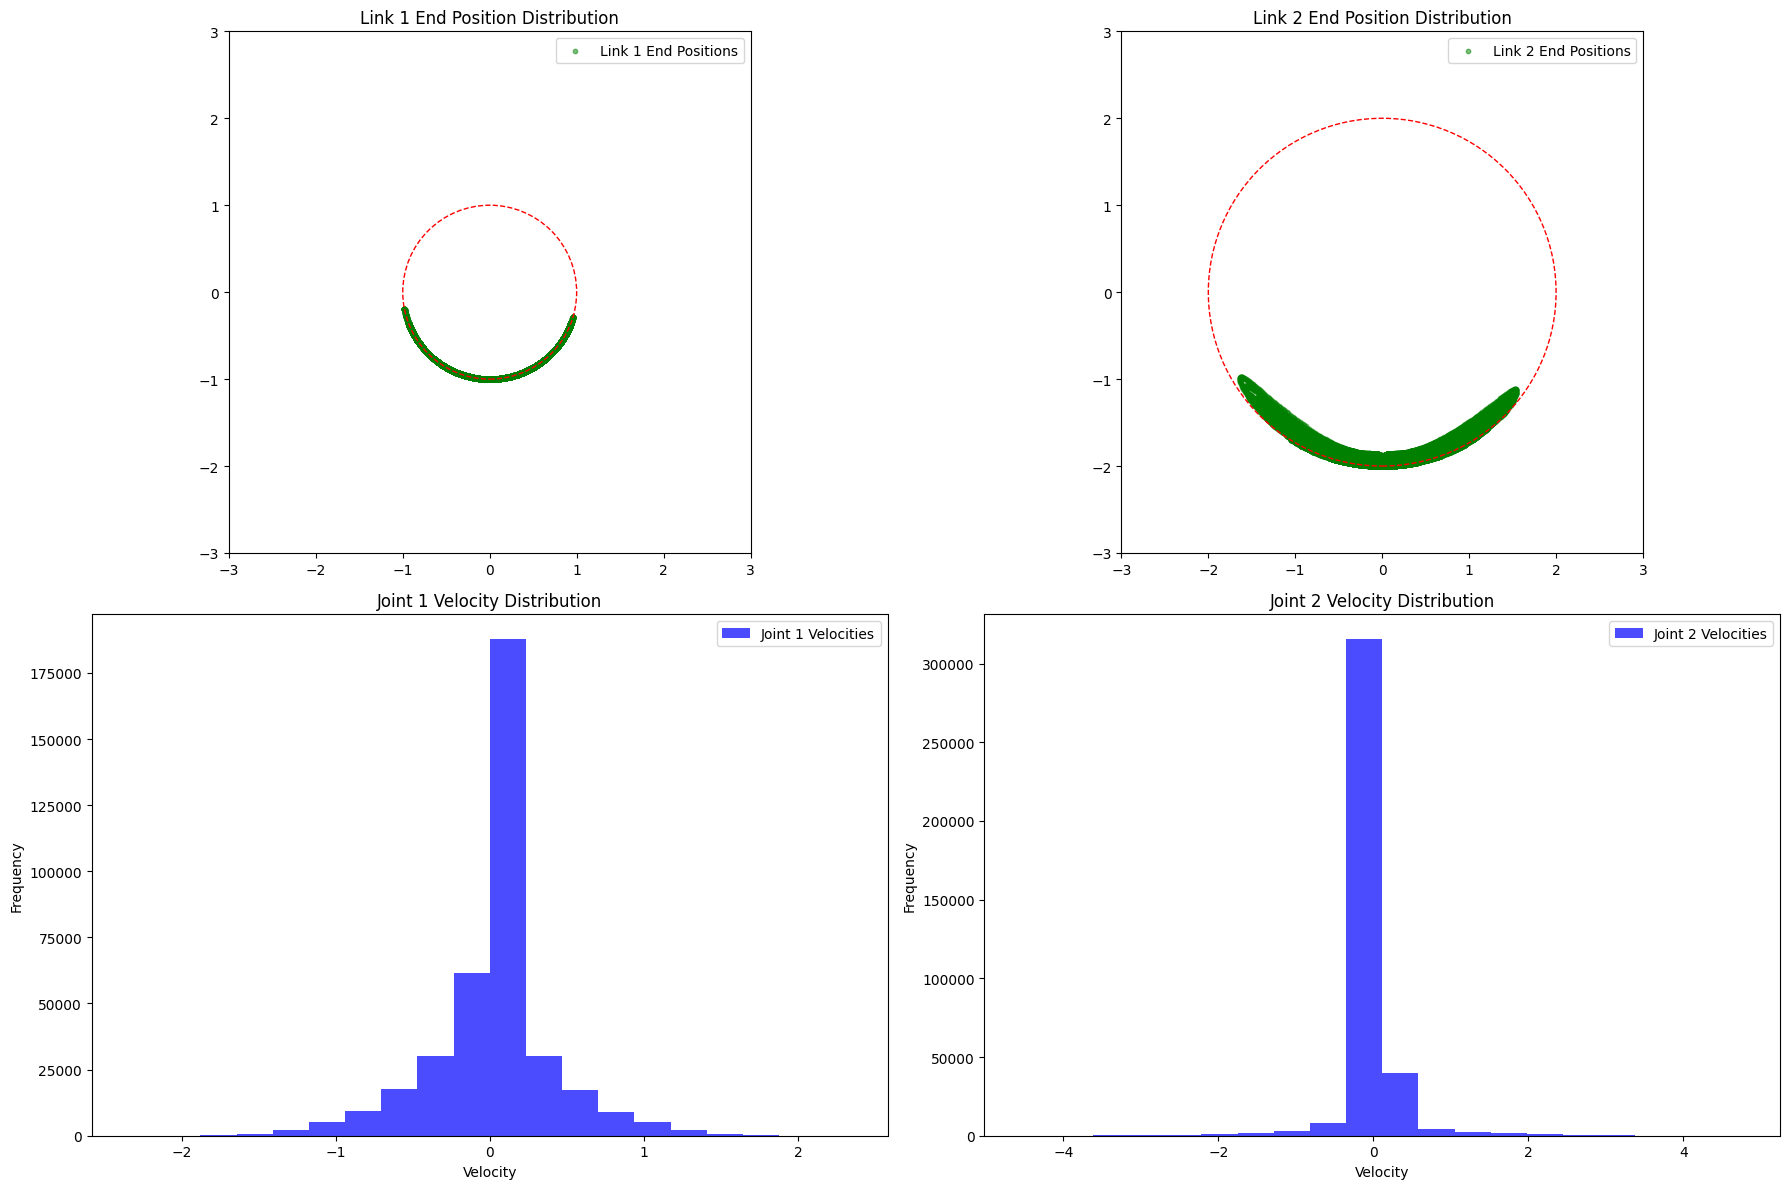

In [ ]:
# Plot the distribution of collected samples
#

plot_positions_velocities_with_fixed_bounds(data['Y'], [1,1])

## Part 2.2: Learning Forward Dynamics

### Training

After the data is collected, you will then need to complete the cell below to use the collected dataset to learn the forward dynamics.

The code already creates the dataset class and loads the dataset with a random 0.8/0.2 train/test split for you. This cell should save the model that it trains. You should use a specific procedure for saving, outlined below. Note that the saving code is not already included so you will have to add it yourself.

In machine learning, it is a very good practice to save not only the final model but also the checkpoints, such that you have a wider range of models to choose from. We provide a code snippet for you and for each epoch of your training, you should use it to save the model at that epoch.

```
model_folder_name = f'epoch_{epoch:04d}_loss_{test_loss:.8f}'
if not os.path.exists(os.path.join(model_dir, model_folder_name)):
    os.makedirs(os.path.join(model_dir, model_folder_name))
torch.save(model.state_dict(), os.path.join(model_dir, model_folder_name, 'dynamics_pt2.pth'))
```

The output from running this code should be a folder as below:

```
models/
    2025-03-08_23-57-50/
        epoch_0001_loss_0.00032930/
            dynamics_pt2.pth
        epoch_0002_loss_0.00009413/
            dynamics_pt2.pth   
        ...  
```

You can see that every time you run this cell, a folder whose name is the time you started will be created under `models`. Checkpoints from all epochs will be saved and then the folder name for saving the checkpoint indicates the epoch number and loss on the holdout test set. Recording checkpoints this way allows you to easily pick the model with the smallest loss.

### Important: choosing the best model

Your code should keep track of the checkpoint with the smallest loss on the test set. You should save the path of that checkpoint to the variable `model_path`. An example value of `model_path` could be `models/2025-03-07_20-14-32/epoch_0046_loss_0.00000005/dynamics_pt2.pth`. In the evaluation code, the checkpoint from `model_path` will be loaded and evaluated.

You should also download the `dynamics_pt2.pth` file to include in your submission.

A common practice with regards to model saving is to only save models with the best test_loss, rather than checkpoint every epoch. If you want, you can modify the save code to do that instead.

### Model Architecture

In lecture, we introduced the trick to use joint accelerations to compute the next state. You will use your neural network to compute the joint accelerations. This will take in your joint angles, joint velocities, and actions applied to the arm and output joint acceleration values for each link. Then you can use your knowledge of analytical kinematics to derive the joint positions and velocities in the next time step given the joint acceleration values.

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import os
import numpy as np
import torch
import torch.nn as nn
import argparse
import time
import pickle
np.set_printoptions(suppress=True)


class DynamicDataset(Dataset):
    def __init__(self, data_file):
        data = pickle.load(open(data_file, "rb" ))
        # X: (N, 6), Y: (N, 4)
        self.X = data['X'].astype(np.float32)
        self.Y = data['Y'].astype(np.float32)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(6, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 4)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


def train(model):
    np.random.seed(42)

    model.train()
    # ---
    # Your code goes here
    global train_loader, device, dt, criterion, optimizer
    running_loss = 0.0

    for X_batch, Y_batch in train_loader:
        X_batch = X_batch.to(device)
        Y_batch = Y_batch.to(device)

        # 1) Zero gradients
        optimizer.zero_grad()

        # 2) Forward pass -> predict accelerations
        pred_acc = model(X_batch)  # shape (batch_size, 2)

        # 3) Decompose X_batch: [q1, q2, qd1, qd2, tau1, tau2]
        q1 = X_batch[:, 0]
        q2 = X_batch[:, 1]
        qd1 = X_batch[:, 2]
        qd2 = X_batch[:, 3]

        # 4) Reconstruct the next state using Euler
        pred_q1_next = q1 + qd1 * dt
        pred_q2_next = q2 + qd2 * dt
        pred_qd1_next = qd1 + pred_acc[:, 0] * dt
        pred_qd2_next = qd2 + pred_acc[:, 1] * dt

        # shape (batch_size, 4)
        pred_next_state = torch.stack(
            [pred_q1_next, pred_q2_next, pred_qd1_next, pred_qd2_next],
            dim=1
        )

        # 5) Compute loss
        loss = criterion(pred_next_state, Y_batch)

        # 6) Backprop & step
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    return epoch_loss


def test(model):
    model.eval()

    # --
    # Your code goes here
    global test_loader, device, dt, criterion
    running_loss = 0.0

    with torch.no_grad():
        for X_batch, Y_batch in test_loader:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            pred_acc = model(X_batch)  # shape (batch_size, 2)

            q1 = X_batch[:, 0]
            q2 = X_batch[:, 1]
            qd1 = X_batch[:, 2]
            qd2 = X_batch[:, 3]

            pred_q1_next = q1 + qd1 * dt
            pred_q2_next = q2 + qd2 * dt
            pred_qd1_next = qd1 + pred_acc[:, 0] * dt
            pred_qd2_next = qd2 + pred_acc[:, 1] * dt

            pred_next_state = torch.stack(
                [pred_q1_next, pred_q2_next, pred_qd1_next, pred_qd2_next],
                dim=1
            )

            loss = criterion(pred_next_state, Y_batch)
            running_loss += loss.item()

    test_loss = running_loss / len(test_loader)
    return test_loss

    # ---

    return test_loss


# The ratio of the dataset used for testing
split = 0.2

# Do NOT change
# We are only using CPU, and GPU is not allowed.
device = torch.device("cpu")

dataset = DynamicDataset('data_pt2.pkl')
dataset_size = len(dataset)
test_size = int(np.floor(split * dataset_size))
train_size = dataset_size - test_size
train_set, test_set = random_split(dataset, [train_size, test_size])

#batch_size = 32 Best 4.60 |epochs = 50
#batch_size = 36 this made it horrible | epochs = 50
#batch_size = 30 3.95 again really bad | epochs = 50
#batch size 8 = 4.15
batch_size = 64

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True)

# The name of the directory to save all the checkpoints
timestr = time.strftime("%Y-%m-%d_%H-%M-%S")
model_dir = os.path.join('models', timestr)

# Keep track of the checkpoint with the smallest test loss and save in model_path
model_path = None


epochs = 8

model = Net().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=.0005)

dt = 0.01  # must match your data generation time step
best_loss = float('inf')

os.makedirs(model_dir, exist_ok=True)


for epoch in range(1, 1 + epochs):
    train_loss = train(model)
    test_loss = test(model)

    # Save checkpoint
    model_folder_name = f'epoch_{epoch:04d}_loss_{test_loss:.8f}'
    checkpoint_dir = os.path.join(model_dir, model_folder_name)
    os.makedirs(checkpoint_dir, exist_ok=True)

    torch.save(model.state_dict(), os.path.join(checkpoint_dir, 'dynamics_pt2.pth'))

    # Track best model
    if test_loss < best_loss:
        best_loss = test_loss
        model_path = os.path.join(checkpoint_dir, 'dynamics_pt2.pth')

    print(f"[Epoch {epoch}/{epochs}] train_loss={train_loss:.6f}, test_loss={test_loss:.6f}")

print("Best model path:", model_path)


[Epoch 1/8] train_loss=0.000030, test_loss=0.000003
[Epoch 2/8] train_loss=0.000002, test_loss=0.000001
[Epoch 3/8] train_loss=0.000001, test_loss=0.000000
[Epoch 4/8] train_loss=0.000000, test_loss=0.000000
[Epoch 5/8] train_loss=0.000000, test_loss=0.000000
[Epoch 6/8] train_loss=0.000000, test_loss=0.000000
[Epoch 7/8] train_loss=0.000000, test_loss=0.000000
[Epoch 8/8] train_loss=0.000000, test_loss=0.000000
Best model path: models/2025-04-03_03-43-49/epoch_0007_loss_0.00000019/dynamics_pt2.pth


## Prediction

After you are done with training, you need to complete the cell below to load the saved checkpoint (in function init_model) and then use it to predict the new state given the current state and action (in function dynamics_step). Please do not modify the arguments to those functions, even though you might not use all of them.

In [ ]:
from arm_dynamics_base import ArmDynamicsBase

class ArmDynamicsStudent(ArmDynamicsBase):
    def init_model(self, model_path, num_links, time_step, device):
        # ---
        # Your code hoes here
        self.model = Net().to(device)
        self.model.load_state_dict(torch.load(model_path, map_location=device))
        self.model.eval()  # set model to evaluation mode

        # store anything you need (e.g., dt, device) for later
        self.dt = time_step
        self.device = device
        # ---
        self.model_loaded = True

    def dynamics_step(self, state, action, dt):

        if self.model_loaded:
            # ---
            # Your code goes here
            # Use the loaded model to predict new state given the current state and action
            # Output should be an array of shape (4,1)

            # 1) Convert inputs to float32 arrays
            # state is shape (4,1): [q1, q2, qd1, qd2]^T
            # action is shape (2,1): [tau1, tau2]^T
            q1, q2, qd1, qd2 = state[0,0], state[1,0], state[2,0], state[3,0]
            tau1, tau2 = action[0,0], action[1,0]

            # 2) Form the model input tensor of shape (1,6)
            x_in = np.array([q1, q2, qd1, qd2, tau1, tau2], dtype=np.float32).reshape(1, -1)
            x_in_torch = torch.from_numpy(x_in).to(self.device)

            # 3) Forward pass: predict accelerations
            with torch.no_grad():
                pred_acc = self.model(x_in_torch)  # shape (1,2)
            pred_acc = pred_acc.cpu().numpy().squeeze()  # shape (2,)

            qdd1, qdd2 = pred_acc[0], pred_acc[1]

            # 4) One-step Euler integration
            dt_e = self.dt  # or dt, if you prefer to use the function's argument
            q1_next = q1 + qd1 * dt_e
            q2_next = q2 + qd2 * dt_e
            qd1_next = qd1 + qdd1 * dt_e
            qd2_next = qd2 + qdd2 * dt_e

            # 5) Reshape into (4,1)
            new_state = np.array([q1_next, q2_next, qd1_next, qd2_next]).reshape(4, 1)
            return new_state
            # ---
        else:
            return state

## Evaluation and Grading

The total number of points for this part is 5. There are 3 types of tests. Your grade for this part will be the average score across each type of test

**For each type, there are 50 tests.** For each test, you get a score of 1, 0.5, or 0. Your final grade for each type is the averaged score across 50 tests * 5.

- *Type 1*: for each test, a constant torque randomly sampled from [-1.5Nm, 1.5Nm] is applied to the first joint of the arm for 5 seconds. If the MSE (Mean Squred Error) between the predicted arm state (arm_student) and the ground truth arm state (arm_teacher) is < 0.0005, you get score 1 for this test. If 0.0005 <= MSE < 0.008, you get score 0.5 for this test. Otherwise you get 0.
- *Type 2*: for each test, a torque that linearly increases from 0 to a random torque in [0.5Nm, 1.5Nm] is applied to the first joint of the arm for 5 seconds. If MSE < 0.0005, you get score 1 for this test. If 0.0005 <= MSE < 0.008, you get score 0.5 for this test. Otherwise you get 0.
- *Type 3*: for each test, one torque is applied for the first 2.5 seconds and another torque is applied for the remaining 2.5 seconds. Both torques are sampled from [-1Nm, 1Nm]. If MSE < 0.015, you get score 1 for this test. If 0.015 <= MSE < 0.05, you get score 0.5 for this test. Otherwise you get 0.


In [ ]:
# DO NOT CHANGE
# Set up grading


import importlib
import score
importlib.reload(score)

# Make sure model_path is correctly set
print(model_path)

# Create the teacher arm
dynamics_teacher = ArmDynamicsTeacher(
    num_links=2,
    link_mass=0.1,
    link_length=1,
    joint_viscous_friction=0.1,
    dt=0.01
)
arm_teacher = Robot(dynamics_teacher)

# Create the student arm
dynamics_student = ArmDynamicsStudent(
    num_links=2,
    link_mass=0.1,
    link_length=1,
    joint_viscous_friction=0.1,
    dt=0.01
)

if model_path is not None:
  dynamics_student.init_model(model_path, num_links=2, time_step=0.01, device=torch.device('cpu'))
  arm_student = Robot(dynamics_student)



models/2025-04-03_03-43-49/epoch_0007_loss_0.00000019/dynamics_pt2.pth


In [ ]:
# DO NOT CHANGE

# Test on randomly sampled torques from [-1.5, 1.5]
score.score_random_torque(arm_teacher, arm_student, gui=False)


----------------------------------------
TEST 1 (Torque = 0.542641286533492 Nm)

average mse: 8.273382085896455e-05
Score: 1/1
----------------------------------------


----------------------------------------
TEST 2 (Torque = -0.958496101281197 Nm)

average mse: 0.0003512001120647521
Score: 1/1
----------------------------------------


----------------------------------------
TEST 3 (Torque = 0.26729646985255084 Nm)

average mse: 5.2060722984692154e-05
Score: 1/1
----------------------------------------


----------------------------------------
TEST 4 (Torque = 0.4976077650772237 Nm)

average mse: 6.477952588706858e-05
Score: 1/1
----------------------------------------


----------------------------------------
TEST 5 (Torque = -0.0029859753948191514 Nm)

average mse: 1.622802793148266e-06
Score: 1/1
----------------------------------------


----------------------------------------
TEST 6 (Torque = -0.5504067089383047 Nm)

average mse: 2.3122520277221885e-05
Score: 1/1
---------

In [ ]:
# DO NOT CHANGE

# Test on torques that linearly increase from 0 to a random number from [0.5, 1.5]
score.score_linear_torques(arm_teacher, arm_student, gui=False)


----------------------------------------
TEST 1 (Torque 0 -> 0.8856603216333729 Nm)

average mse: 7.293227508639655e-06
Score: 1/1
----------------------------------------


----------------------------------------
TEST 2 (Torque 0 -> 0.5103759746797008 Nm)

average mse: 3.960226155886871e-06
Score: 1/1
----------------------------------------


----------------------------------------
TEST 3 (Torque 0 -> 0.8168241174631377 Nm)

average mse: 6.334840423385194e-06
Score: 1/1
----------------------------------------


----------------------------------------
TEST 4 (Torque 0 -> 0.8744019412693059 Nm)

average mse: 7.169613633483212e-06
Score: 1/1
----------------------------------------


----------------------------------------
TEST 5 (Torque 0 -> 0.7492535061512953 Nm)

average mse: 5.324839677708833e-06
Score: 1/1
----------------------------------------


----------------------------------------
TEST 6 (Torque 0 -> 0.6123983227654238 Nm)

average mse: 2.3883830214459307e-06
Score: 1

In [ ]:
# DO NOT CHANGE

# Test on one torque applied to the first 2.5s and another torque applied to the second 2.5s
# Both torques are sampled from [-1, 1]
score.score_two_torques(arm_teacher, arm_student, gui=False)


----------------------------------------
TEST 1 (Torque 1 = 0.542641286533492 Nm,  Torque 2 = -0.21494151210682544 Nm)

average mse: 9.577798999711607e-05
Score: 1/1
----------------------------------------


----------------------------------------
TEST 2 (Torque 1 = -0.958496101281197 Nm,  Torque 2 = -0.8130792508826994 Nm)

average mse: 0.00030037304303632184
Score: 1/1
----------------------------------------


----------------------------------------
TEST 3 (Torque 1 = 0.26729646985255084 Nm,  Torque 2 = 0.6422113156738569 Nm)

average mse: 3.4026539443563674e-05
Score: 1/1
----------------------------------------


----------------------------------------
TEST 4 (Torque 1 = 0.4976077650772237 Nm,  Torque 2 = -0.6976959607148723 Nm)

average mse: 0.00015559505094725346
Score: 1/1
----------------------------------------


----------------------------------------
TEST 5 (Torque 1 = -0.0029859753948191514 Nm,  Torque 2 = -0.23177110261560085 Nm)

average mse: 5.093502197415725e-06


# Part 3: MPC Controller with Learned Dynamics Model

## Part 3.1: Model Architecture

We have a base class Model and a subclass for the 2-link arm. The class Model is a base class for our models. In compute_next_state() method, you have to use the trick to use joint accelerations to compute the next state similar to what you did in Part 2.

In the `Model2Link` class you will use a neural network to compute the joint accelerations by implementing `compute_qddot()` method. This will take 6 values (2 joint angles, 2 joint velocities and 2 actions applied to the arm) and output 2 joint acceleration values

Do not change the arguments for the `__init__()` method even if you do not use them.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Model(nn.Module):
	def __init__(self, num_links, time_step):
		super().__init__()
		self.num_links = num_links
		self.time_step = time_step

	def forward(self, x):
		qddot = self.compute_qddot(x)
		state = x[:, :2*self.num_links]
		next_state = self.compute_next_state(state, qddot)
		return next_state

	def compute_next_state(self, state, qddot):
		# state: shape (batch_size, 4) → [q1, q2, qd1, qd2]
		# qddot: shape (batch_size, 2) → [qdd1, qdd2]

		q = state[:, :self.num_links]         # (batch_size, 2)
		q_dot = state[:, self.num_links:]     # (batch_size, 2)

		dt = self.time_step

		q_next = q + q_dot * dt               # q_next = q + q_dot * dt
		q_dot_next = q_dot + qddot * dt       # q_dot_next = q_dot + qddot * dt

		next_state = torch.cat([q_next, q_dot_next], dim=1)  # (batch_size, 4)
		return next_state

	def compute_qddot(self, x):
		# x: shape (batch_size, 6) → [q1, q2, qd1, qd2, tau1, tau2]
		qddot = self.net(x)  # output: shape (batch_size, 2)
		return qddot

class Model2Link(Model):
    def __init__(self, time_step):
        super().__init__(2, time_step)
        self.net = nn.Sequential(
            nn.Linear(6, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 2)
        )

    def compute_qddot(self, x):
        return self.net(x)

## Part 3.2: Collect Data
Similar to part 2, we will collect data which will be used to learn a forward model for our 2 link robot arm. Once we have learnt a forward model you will be evaluated on your MPC Controller that uses the learnt dynamics model instead of the true dynamics.

You can modify the collect_data function or write any of your own functions however you choose to. You will be evaluated on the **2 Link Robot**

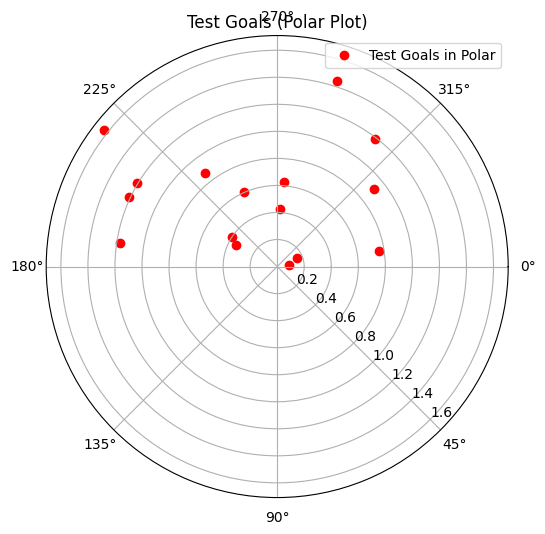

In [ ]:
'''
import numpy as np
import matplotlib.pyplot as plt

# Suppose 'test_goals' is Nx2: columns are [x, y].
# e.g., from your logs:
test_goals = np.array([
    [ 0.75251482, -0.1174562 ],
    [ 0.43944919, -1.37213552],
    [-0.30565974, -0.16306325],
    [ 0.14639443, -0.0654495 ],
    [ 0.72494077, -0.94636539],
    [ 0.08871268, -0.00841117],
    [-1.28186573, -1.00949129],
    [-0.33161873, -0.21546116],
    [ 0.04879792, -0.62616168],
    [-0.53099484, -0.69004   ],
    [-1.09794087, -0.51452095],
    [-0.24663534, -0.55252743],
    [ 0.71560687, -0.57266001],
    [ 0.01919497, -0.42895093],
    [-1.16309277, -0.17094326],
    [-1.03561108, -0.61476256],
    [ 0.75251482, -0.1174562 ],
    [ 0.43944919, -1.37213552],
    [-0.30565974, -0.16306325],
    [ 0.14639443, -0.0654495 ],
    [ 0.72494077, -0.94636539],
    [ 0.08871268, -0.00841117],
    [-1.28186573, -1.00949129],
    [-0.33161873, -0.21546116],
    [ 0.04879792, -0.62616168],
    [-0.53099484, -0.69004   ],
    [-1.09794087, -0.51452095],
    [-0.24663534, -0.55252743],
    [ 0.71560687, -0.57266001],
    [ 0.01919497, -0.42895093],
    [-1.16309277, -0.17094326],
    [-1.03561108, -0.61476256]
])

# 1) Compute r and θ
r = np.sqrt(test_goals[:,0]**2 + test_goals[:,1]**2)
theta = np.arctan2(test_goals[:,1], test_goals[:,0])  # angle in [-π, π]

# 2) Plot in polar coordinates
plt.figure(figsize=(6,6))
ax = plt.subplot(111, projection='polar')
ax.scatter(theta, r, color='r', label='Test Goals in Polar')
ax.set_theta_zero_location("E")  # optional: zero degrees at x-axis
ax.set_theta_direction(-1)       # optional: increase theta clockwise
ax.set_rlabel_position(45)       # optional: move radial labels away from overlap
ax.set_title("Test Goals (Polar Plot)")
ax.legend()
plt.show() '''

In [ ]:
# Teacher arm with 2 links
from arm_dynamics_teacher import ArmDynamicsTeacher
from robot import Robot
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import os
import numpy as np
import torch
import torch.nn as nn
import argparse
import time
import pickle
from tqdm import tqdm

dynamics_teacher = ArmDynamicsTeacher(
    num_links=2,
    link_mass=0.1,
    link_length=1,
    joint_viscous_friction=0.1,
    dt=0.01)

# Controller
controller = MPC()

arm = Robot(dynamics_teacher)
arm.reset()

def collect_data(arm):
    """
    Collect 10,000 samples in episodes of 250 steps each.
    The arm always starts from the fixed rest pose (q1=-pi/2, q2=0, zero velocities).
    Goals are sampled uniformly from the bottom half of a circle (polar coordinates):
      r is in [0.05, 1.95] and theta in [-pi, 0].
    For each step, 70% of the time use random torque and 30% use MPC-based torque.
    """
    global controller

    num_samples = 20000
    steps_per_episode = 250
    episodes_needed = num_samples // steps_per_episode
    dt = arm.dynamics.dt

    X = np.zeros((num_samples, arm.dynamics.get_state_dim() + arm.dynamics.get_action_dim()), dtype=np.float32)
    Y = np.zeros((num_samples, arm.dynamics.get_state_dim()), dtype=np.float32)
    i = 0

    for ep in tqdm(range(episodes_needed), desc="Collecting data"):
        arm.reset()
        init_state = np.zeros((4, 1))
        init_state[0, 0] = -np.pi / 2.0
        arm.set_state(init_state)

        r = np.random.uniform(0.05, 1.95)
        theta = np.random.uniform(-np.pi, 0)
        goal = np.array([[r * np.cos(theta)], [r * np.sin(theta)]])
        arm.goal = goal

        prev_action = np.zeros((2, 1))

        for t in range(steps_per_episode):
            if i >= num_samples:
                break

            state = arm.get_state()

            if t % controller.control_horizon == 0:
                tau = controller.compute_action(
                    arm.dynamics, state.reshape(-1, 1), goal, prev_action)
                prev_action = tau.copy()
            else:
                tau = prev_action.copy()

            sa = np.concatenate([state.flatten(), tau.flatten()])
            arm.set_action(tau)
            arm.advance()
            next_state = arm.get_state().flatten()

            X[i, :] = sa
            Y[i, :] = next_state
            i += 1

    return X, Y


In [ ]:
import pickle

# Call the function you have defined above to collect data
X, Y = collect_data(arm)
save_dir = 'dataset'
if not os.path.exists(save_dir):
  os.makedirs(save_dir)

# Save the collected data in the data_pt3.pkl file
data = {'X': X, 'Y': Y}

pickle.dump(data, open(os.path.join(save_dir, 'data_pt3.pkl'), "wb" ))

# Visualization

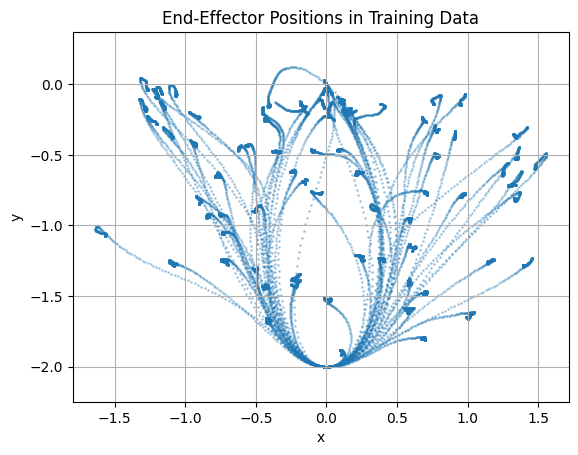

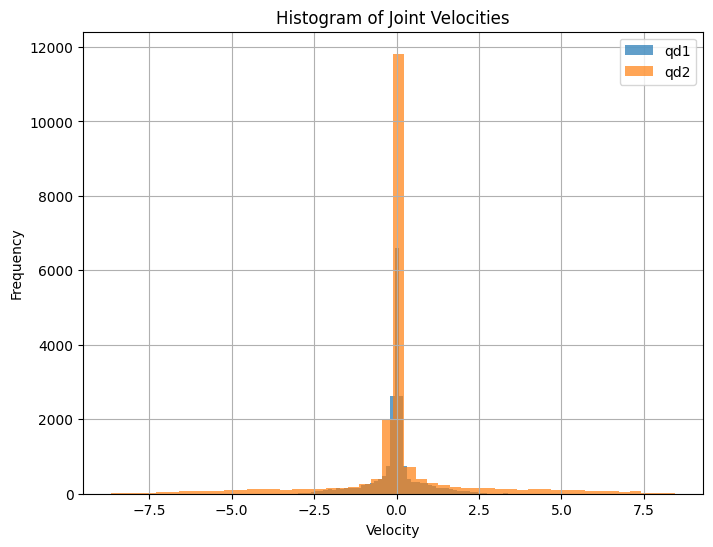

In [ ]:
import matplotlib.pyplot as plt
def compute_ee_position(q1, q2, link_length=1.0):
    x1 = link_length * np.cos(q1)
    y1 = link_length * np.sin(q1)
    x2 = x1 + link_length * np.cos(q1 + q2)
    y2 = y1 + link_length * np.sin(q1 + q2)
    return x2, y2

q1 = Y[:, 0]
q2 = Y[:, 1]

ee_positions = np.array([compute_ee_position(q1[i], q2[i]) for i in range(len(q1))])
x_ee, y_ee = ee_positions[:, 0], ee_positions[:, 1]

plt.scatter(x_ee, y_ee, s=1, alpha=0.3)
plt.title("End-Effector Positions in Training Data")
plt.xlabel("x")
plt.ylabel("y")
plt.axis("equal")
plt.grid(True)
plt.show()

import matplotlib.pyplot as plt

# Extract individual velocities from Y
qd1 = Y[:, 2]
qd2 = Y[:, 3]

plt.figure(figsize=(8, 6))
plt.hist(qd1, bins=50, alpha=0.7, label="qd1")
plt.hist(qd2, bins=50, alpha=0.7, label="qd2")
plt.title("Histogram of Joint Velocities")
plt.xlabel("Velocity")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

## Part 3.3: Training the forward model
By now you would be familiar with the basic skeleton of training a forward model.

The starter code already creates the dataset class and loads the dataset with a random 0.8/0.2 train/test split for you. This script should save the model that it trains. You should use a specific procedure for saving, outlined below.

In machine learning, it is a very good practice to save not only the final model but also the checkpoints. Our starter code already configures save_dir for you and for each epoch of your training, you should use the following code to save the model at that epoch.

```
model_folder_name = f'epoch_{epoch:04d}_loss_{test_loss:.8f}'
if not os.path.exists(os.path.join(args.save_dir, model_folder_name)):
    os.makedirs(os.path.join(args.save_dir, model_folder_name))
torch.save(model.state_dict(), os.path.join(args.save_dir, model_folder_name, 'dynamics_pt3.pth'))
print(f'model saved to {os.path.join(args.save_dir, model_folder_name, "dynamics_pt3.pth")}\n')
```
The output from running this code should be a folder as below:

```
models/
    2021-03-24_23-57-50/
        epoch_0001_loss_0.00032930/
            dynamics_pt3.pth
        epoch_0002_loss_0.00009413/
            dynamics_pt3.pth   
        ...  
```
You can implement the functions below as you please to collect data

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import tqdm
import pickle
import torch.optim as optim
import argparse
import time

class DynamicDataset(Dataset):
  def __init__(self, datafile):
    data = pickle.load(open(datafile, 'rb'))
    # X: (N, 6), Y: (N, 4)
    self.X = data['X'].astype(np.float32)
    self.Y = data['Y'].astype(np.float32)

  def __len__(self):
    return self.X.shape[0]

  def __getitem__(self, idx):
    return self.X[idx], self.Y[idx]


def train_one_epoch(model, train_loader, device, dt, criterion, optimizer):
    model.train()
    running_loss = 0.0

    for X_batch, Y_batch in train_loader:
        X_batch = X_batch.to(device)
        Y_batch = Y_batch.to(device)

        optimizer.zero_grad()
        pred_acc = model.compute_qddot(X_batch)

        q1 = X_batch[:, 0]
        q2 = X_batch[:, 1]
        qd1 = X_batch[:, 2]
        qd2 = X_batch[:, 3]

        pred_q1_next = q1 + qd1 * dt
        pred_q2_next = q2 + qd2 * dt
        pred_qd1_next = qd1 + pred_acc[:, 0] * dt
        pred_qd2_next = qd2 + pred_acc[:, 1] * dt

        pred_next_state = torch.stack([pred_q1_next, pred_q2_next, pred_qd1_next, pred_qd2_next], dim=1)
        loss = criterion(pred_next_state, Y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    return running_loss / len(train_loader)


def test(model, test_loader, device, dt, criterion):
    model.eval()
    running_loss = 0.0

    with torch.no_grad():
        for X_batch, Y_batch in test_loader:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            pred_acc = model.compute_qddot(X_batch)

            q1 = X_batch[:, 0]
            q2 = X_batch[:, 1]
            qd1 = X_batch[:, 2]
            qd2 = X_batch[:, 3]

            pred_q1_next = q1 + qd1 * dt
            pred_q2_next = q2 + qd2 * dt
            pred_qd1_next = qd1 + pred_acc[:, 0] * dt
            pred_qd2_next = qd2 + pred_acc[:, 1] * dt

            pred_next_state = torch.stack([pred_q1_next, pred_q2_next, pred_qd1_next, pred_qd2_next], dim=1)
            loss = criterion(pred_next_state, Y_batch)
            running_loss += loss.item()

    return running_loss / len(test_loader)


def train_forward_model():

	# --
	# Implement this function
  # --

  # Keep track of the checkpoint with the smallest test loss and save in model_path
  model_path = None
  max_test_loss = 1e4
  model = Model2Link(0.01)

  #datafile = 'dataset/data_pt3.pkl'
  datafile = 'data_pt3.pkl'
  split = 0.2
  dataset = DynamicDataset(datafile)
  dataset_size = len(dataset)
  test_size = int(np.floor(split * dataset_size))
  train_size = dataset_size - test_size
  train_set, test_set = random_split(dataset, [train_size, test_size])

  train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
  test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=True)

  # The name of the directory to save all the checkpoints
  timestr = time.strftime("%Y-%m-%d_%H-%M-%S")
  model_dir = os.path.join('models', timestr)

  device = torch.device("cpu")
  model = model.to(device)
  dt = 0.01
  criterion = nn.MSELoss()
  optimizer = optim.Adam(model.parameters(), lr=0.001)

  os.makedirs(model_dir, exist_ok=True)

  epochs=40

  for epoch in range(1, 1 + epochs):
    train_loss = train_one_epoch(model, train_loader, device, dt, criterion, optimizer)
    test_loss = test(model, test_loader, device, dt, criterion)

    model_folder_name = f'epoch_{epoch:04d}_loss_{test_loss:.8f}'
    save_path = os.path.join(model_dir, model_folder_name)

    if not os.path.exists(save_path):
      os.makedirs(save_path)

    torch.save(model.state_dict(), os.path.join(save_path, 'dynamics_pt3.pth'))
    print(f'model saved to {os.path.join(save_path, "dynamics_pt3.pth")}\n')

    if test_loss < max_test_loss:
      max_test_loss = test_loss
      model_path = os.path.join(save_path, 'dynamics_pt3.pth')

    print(f"[Epoch {epoch}/{epochs}] train_loss={train_loss:.6f}, test_loss={test_loss:.6f}")

  return model_path

In [ ]:
model_path = train_forward_model()

model saved to models/2025-04-03_02-04-44/epoch_0001_loss_0.00059352/dynamics_pt3.pth

[Epoch 1/40] train_loss=0.002383, test_loss=0.000594
model saved to models/2025-04-03_02-04-44/epoch_0002_loss_0.00014755/dynamics_pt3.pth

[Epoch 2/40] train_loss=0.000229, test_loss=0.000148
model saved to models/2025-04-03_02-04-44/epoch_0003_loss_0.00011405/dynamics_pt3.pth

[Epoch 3/40] train_loss=0.000106, test_loss=0.000114
model saved to models/2025-04-03_02-04-44/epoch_0004_loss_0.00006517/dynamics_pt3.pth

[Epoch 4/40] train_loss=0.000073, test_loss=0.000065
model saved to models/2025-04-03_02-04-44/epoch_0005_loss_0.00005614/dynamics_pt3.pth

[Epoch 5/40] train_loss=0.000053, test_loss=0.000056
model saved to models/2025-04-03_02-04-44/epoch_0006_loss_0.00004367/dynamics_pt3.pth

[Epoch 6/40] train_loss=0.000049, test_loss=0.000044
model saved to models/2025-04-03_02-04-44/epoch_0007_loss_0.00004034/dynamics_pt3.pth

[Epoch 7/40] train_loss=0.000035, test_loss=0.000040
model saved to model

## Part 3.4: Completing ArmDynamicsStudent

After you are done with training, you need to complete ArmDynamicsStudent class following the comments below to load the saved checkpoint (in function init_model) and then use it to predict the new state given the current state and action (in function dynamics_step). Please do not modify the arguments to those functions, even though you might not use all of them.

In [ ]:
from arm_dynamics_base import ArmDynamicsBase

class ArmDynamicsStudent(ArmDynamicsBase):
    def init_model(self, model_path, num_links, time_step, device):
        # ---
        self.model = Model2Link(time_step)
        self.model.load_state_dict(torch.load(model_path, map_location=device))
        self.model.to(device)
        self.model.eval()

        self.device = device
        self.dt = time_step
        self.model_loaded = True
        # ---
        self.model_loaded = True

    def dynamics_step(self, state, action, dt):
        if self.model_loaded:
            # ---
            # Convert (4,1) and (2,1) inputs to (1,6) batch
            q1, q2, qd1, qd2 = state.flatten()
            tau1, tau2 = action.flatten()

            x_in = np.array([q1, q2, qd1, qd2, tau1, tau2], dtype=np.float32).reshape(1, -1)
            x_tensor = torch.from_numpy(x_in).to(self.device)

            with torch.no_grad():
                pred_acc = self.model.compute_qddot(x_tensor).cpu().numpy().squeeze()

            qdd1, qdd2 = pred_acc

            # One-step Euler integration
            q1_next = q1 + qd1 * self.dt
            q2_next = q2 + qd2 * self.dt
            qd1_next = qd1 + qdd1 * self.dt
            qd2_next = qd2 + qdd2 * self.dt

            new_state = np.array([q1_next, q2_next, qd1_next, qd2_next]).reshape(4, 1)
            return new_state
            # ---
        else:
            return state

## Manually Testing the MPC Controller with the learnt dynamics model
We will now use the learnt dynamics model that you have trained. The model is loaded in the dynamics.init_model method. You can modify the goal positions to see how well is the controller performing similar to what you did before. Feel free to play around with the code in this cell to test your performance before the grading part.


In [ ]:
import sys
import numpy as np
from arm_dynamics_teacher import ArmDynamicsTeacher
from robot import Robot
from render import Renderer
from score import *
import torch
import time

# Teacher arm with 2 links
dynamics_teacher = ArmDynamicsTeacher(
    num_links=2,
    link_mass=0.1,
    link_length=1,
    joint_viscous_friction=0.1,
    dt=0.01)

arm = Robot(dynamics_teacher)
arm.reset()

gui = False
action = np.zeros((arm.dynamics.get_action_dim(), 1))
if gui:
  renderer = Renderer()
  time.sleep(1)

# Controller
controller = MPC()
dynamics_student = ArmDynamicsStudent(
    num_links=2,
    link_mass=0.1,
    link_length=1,
    joint_viscous_friction=0.1,
    dt=0.01)
device = torch.device('cpu')

# model_path should have the path to the best model that you have trained so far
# which you would like to use for testing the controller

import os
import re

def find_best_model_path(base_dir="models"):
    """
    1) Find all immediate subdirs of `base_dir`
       and sort them by creation time (the newest is last).
    2) In the newest subdir, look for folders named epoch_XXXX_loss_YYYY
       and pick the one with the lowest `YYYY`.
    3) Return the path to the `dynamics_pt3.pth` in that subfolder.
    """
    # Gather all subdirs in `models`
    subdirs = [os.path.join(base_dir, d)
               for d in os.listdir(base_dir)
               if os.path.isdir(os.path.join(base_dir, d))]

    if not subdirs:
        print(f"No subdirectories found in {base_dir}")
        return None

    # Sort subdirs by creation time (the newest is last)
    subdirs.sort(key=lambda p: os.path.getctime(p))
    newest_dir = subdirs[-1]

    print("Newest folder:", newest_dir)

    best_loss = float('inf')
    best_path = None

    # Now search inside the newest_dir for the epoch folders
    for root, dirs, files in os.walk(newest_dir):
        for file in files:
            if file == "dynamics_pt3.pth":
                # Folder name should match: epoch_XXXX_loss_YYYY
                match = re.search(r"epoch_\d+_loss_(\d+\.\d+)", root)
                if match:
                    loss = float(match.group(1))
                    if loss < best_loss:
                        best_loss = loss
                        best_path = os.path.join(root, file)

    if best_path is None:
        print(f"No checkpoints found in newest folder: {newest_dir}")
    else:
        print(f"Best model in newest folder: {best_path} (loss={best_loss})")

    return best_path


# Find the best model from the newest training run
best_model = find_best_model_path("models")
if best_model is None:
    raise RuntimeError("No valid checkpoint found in the newest folder.")
print("Using best model:", best_model)

import shutil
# Copy the best checkpoint to a file named 'dynamics_pt3.pth' in the current directory
shutil.copyfile(best_model, 'dynamics_pt3.pth')

# Initialize the dynamics student using this checkpoint
dynamics_student.init_model('dynamics_pt3.pth', 2, 0.01, device)


# Control loop
action = np.zeros((arm.dynamics.get_action_dim(), 1))
goal = np.zeros((2, 1))
goal[0, 0] = 2.7
goal[1, 0] = 0.5
arm.goal = goal

# Prepare lists for logging metrics
distances = []
velocities = []
time_stamps = []

dt = 0.01
time_limit = 2.5
num_steps = round(time_limit / dt)

for s in range(num_steps):
    t = time.time()
    arm.advance()

    if gui:
        renderer.plot([(arm, "tab:blue")])

    # Sleep to keep simulation time roughly dt
    time.sleep(max(0, dt - (time.time() - t)))

    # Every control_horizon steps, compute new action and log metrics
    if s % controller.control_horizon == 0:
        state = arm.get_state()
        # Compute the current end-effector position using the teacher's FK
        pos_ee = dynamics_teacher.compute_fk(state)
        # Compute distance from goal to EE position
        dist = np.linalg.norm(goal - pos_ee)
        # Compute end-effector velocity (using teacher dynamics, for instance)
        vel_ee = np.linalg.norm(arm.dynamics.compute_vel_ee(state))

        # Log the metrics
        print(f'At timestep {s}: Distance to goal: {dist}, Velocity of EE: {vel_ee}')
        distances.append(dist)
        velocities.append(vel_ee)
        time_stamps.append(s * dt)

        # Compute new action with your learned dynamics model via MPC
        action = controller.compute_action(dynamics_student, state, goal, action)
        arm.set_action(action)

'''
# After the control loop, plot the logged data
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(time_stamps, distances, '-o', markersize=3)
plt.xlabel("Time (s)")
plt.ylabel("Distance to goal")
plt.title("Distance to Goal Over Time")
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(time_stamps, velocities, '-o', markersize=3)
plt.xlabel("Time (s)")
plt.ylabel("End-Effector Velocity")
plt.title("EE Velocity Over Time")
plt.grid(True)

plt.tight_layout()
plt.show()'''




Newest folder: models/2025-04-03_02-04-44
Best model in newest folder: models/2025-04-03_02-04-44/epoch_0040_loss_0.00000619/dynamics_pt3.pth (loss=6.19e-06)
Using best model: models/2025-04-03_02-04-44/epoch_0040_loss_0.00000619/dynamics_pt3.pth
At timestep 0: Distance to goal: 3.67967389859482, Velocity of EE: 7.715274834628325e-18
At timestep 10: Distance to goal: 3.563143400825772, Velocity of EE: 1.7640915482291262
At timestep 20: Distance to goal: 3.2830044642173517, Velocity of EE: 1.4793137841393313
At timestep 30: Distance to goal: 2.9586961738539395, Velocity of EE: 0.37292213630832594
At timestep 40: Distance to goal: 2.6488937084369226, Velocity of EE: 1.0095422829506469
At timestep 50: Distance to goal: 2.3489762532801666, Velocity of EE: 2.4349009730969446
At timestep 60: Distance to goal: 2.022886204019523, Velocity of EE: 3.4606193376295806
At timestep 70: Distance to goal: 1.6751673218139098, Velocity of EE: 3.788582366628885
At timestep 80: Distance to goal: 1.3752482

NameError: name 'plt' is not defined

## Grading and Evaluation of Part 3
You will be evaluated on how well your controller+learnt dynamics works together. The scoring functions consists of 16 random test goals all of which will be below the x axis and between 0.05 to 1.95 lengths away from the origin.
The controller will call the compute_action method from your MPC class and apply the action for 10 timesteps
```
action = controller.compute_action(dynamics_student, state, goal, action)
```

Each test will run the robot arm for **2.5 seconds**. At the end of the 2.5 seconds the test will be:

A success if your end effectors meet this criteria:
`distance_to_goal < 0.2 and vel_ee < 0.5`

A partial success if your end effectors meet this criteria:
`distance_to_goal < 0.3 and vel_ee < 0.5`

After all of the tests are complete, your score is summed up and then scaled out of 5 total points. You need 15 out of the 16 tests to succeed to get a full score.

In [ ]:
controller = MPC()
dynamics_student = ArmDynamicsStudent(
    num_links=2,
    link_mass=0.1,
    link_length=1,
    joint_viscous_friction=0.1,
    dt=0.01)

model_path = 'dynamics_pt3.pth'
gui=False

In [ ]:
# DO NOT CHANGE
score_mpc_learnt_dynamics(controller, dynamics_student, model_path, gui)

Part2: EVALUATING CONTROLLER + LEARNED DYNAMICS
-----------------------------------------------
NUM_LINKS: 2
Test  1
Success! :)
 Goal: [ 0.75251482 -0.1174562 ], Final position: [ 0.75034057 -0.11887629], Final velocity: [0.07307093]
score: 0.5/0.5
Test  2
Success! :)
 Goal: [ 0.43944919 -1.37213552], Final position: [ 0.42815487 -1.3641514 ], Final velocity: [0.08062868]
score: 0.5/0.5
Test  3
Fail :(
 Goal: [-0.30565974 -0.16306325], Final position: [-0.05658146  0.06373218], Final velocity: [0.10114689]
score: 0/0.5
Test  4
Success! :)
 Goal: [ 0.14639443 -0.0654495 ], Final position: [ 0.12886177 -0.10859077], Final velocity: [0.2098143]
score: 0.5/0.5
Test  5
Success! :)
 Goal: [ 0.72494077 -0.94636539], Final position: [ 0.73222515 -0.9462978 ], Final velocity: [0.04627267]
score: 0.5/0.5
Test  6
Success! :)
 Goal: [ 0.08871268 -0.00841117], Final position: [0.0417703  0.05176222], Final velocity: [0.17346449]
score: 0.5/0.5
Test  7
Success! :)
 Goal: [-1.28186573 -1.00949129], 

Time Limit
*   MPC evaluation (Part 1): 30 minutes
*   Data Collection with MPC (Part 2): 1 hour 20 minutes
*   Training the forward dynamics model (Part 3): 40 minutes

Note: Time limits are general guidelines. While your code must run within the allotted time, you should be able to achieve full score with a much shorter runtime


Hints and Suggestions:
1. You can use your MPC Controller in your data collection to gather better training samples
2. A good cost function to evaluate your trajectory in MPC is very important and you can use both distance and velocity metrics to define the cost function.
3. As mentioned in the lecture, a constant torque with pseudo gradients seems to work well for this project. You can also use multiple delta values to gather more trajectories to choose from.
4. Since we are passing the MPC object to the controller you can instantiate the MPC class with different parameters like the planning horizon, delta values etc.
5. To speed up data collection, avoid using np.concatenate(), np.stack() or np.append() like functions on your X and Y arrays. Instead, initialize X and Y arrays with all zeros using the correct shape and then fill in the values one by one. This is much faster in numpy. Using Ray is optional

# Other Requirements and Hints

Time Limit
*   MPC evaluation (Part 1): 30 minutes
*   Learned Forward Model (Part 2): Less than a hundred epochs of training (<= 25 mins) should suffice for achieving the full points. Again, the shorter your model training time is the better.
*   Data Collection with MPC (Part 3): 1 hour 20 minutes
*   Training the forward dynamics model (Part 3): 40 minutes

Note: Time limits are general guidelines. While your code must run within the allotted time, you should be able to achieve full score with a much shorter runtime


Hints and Suggestions:
1. Choosing the right policy to collect datasets for this project (parts 2 and 3) is important. You need to think about how to do it properly so that your trained model will pass the tests successfully. It is in general very hard to learn the ground truth forward dynamics completely (that works for any distribution of actions), and during testing small errors can accumulate, leading to drastic failure in the end. You might want to try overfitting on the test cases to begin with.
2. Make sure that your dataset for part 2 is less than 100 Mb, which is pretty much sufficient for achieving full marks. Collecting datasets can be time-consuming and you could parallelize this process for some speed-up using [ray](https://www.ray.io/). Make sure your data collection in part 2 takes <= 25 mins.
3. You can use your MPC Controller in your data collection for part 3 to gather better training samples
4. A good cost function to evaluate your trajectory in MPC is very important and you can use both distance and velocity metrics to define the cost function.
5. As mentioned in the lecture, a constant torque with pseudo gradients seems to work well for this project. You can also use multiple delta values to gather more trajectories to choose from.
6. Since we are passing the MPC object to the controller you can instantiate the MPC class with different parameters like the planning horizon, delta values etc.
7. To speed up data collection, avoid using np.concatenate(), np.stack() or np.append() like functions on your X and Y arrays. Instead, initialize X and Y arrays with all zeros using the correct shape and then fill in the values one by one. This is much faster in numpy. Using Ray is optional
8. You may reuse your part 2 model for part 3, but it may be beneficial to re-collect data to train a model specific to part 3.

General Tips and Requirements
- NO GPU: No GPU is required or allowed for this assignment and we will test your code without GPUs.
- Loss Function: This is essentially a regression problem so think about what losses are suitable for regression.
- Optimizer: While it is possible to use a simple optimizer to achieve the desired accuracy, the training time can be quite high. There exists a number of optimizers implemented in PyTorch that have much faster convergence.
- Seeding. Please use seeding in your code to make sure your results are reproducible.